<a href="https://colab.research.google.com/github/ar1905ru/Neural-Networkk/blob/main/Resnet_VGG_Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import the DataSet

In [ ]:
import numpy as np
import time
import copy
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import tensorflow as tf
import tensorflow.keras as keras

import random
from sklearn.preprocessing import MultiLabelBinarizer



# Data Processing

Downloading the apple folder containing 3 different type of leaf dieases - Apple_Scab, Apple_Black Rot, Cedar Apple Rust and Healthy leaves. 


In [ ]:
# Set the transformation for each dataset folder
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

Dividing each folder into 3 different folders, they are train, val, and test. Then, we divide each group by 80% for train data (divide them for train and validation with 90:10 proportion) and 20% for test data. 


Model cannot be processed without preparing the data and transforming to the required size. Therefore, we have to resize it and also crop the dataset with the same dimension with the first layer of the model.
After transforming the image, we can load it to our code using ImageFolder method and applying transform to the dataset to it. 

The model is trained using all of the training dataset, but it will consume a lot of time. Therefore, we have to create batches to reduce the computation time. To make sure that the batches are random, shuffling the parameter to true.

Finally, we retrieve the number of the images and the class names, and also we can enable the GPU using the torch.device function. 

In [ ]:
# Import the dataset
data_dir = '/content/drive/MyDrive/Rutgers/Apple Disease Classification/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transforms[x])
                  for x in ['train', 'val', 'test']}

In [ ]:
 # Shuffle the dataset and create batches from the dataset
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2, shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

In [ ]:
# Get the number of images in each folder
data_size = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [ ]:
# Get the class name
class_names = image_datasets['train'].classes

In [ ]:
# Enable the GPU if it exists
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

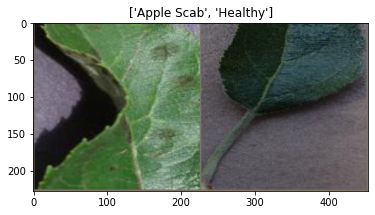

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

# Create a function to train and to evaluate the model



Comparing VGG-16, ResNet-18, and AlexNet architecture to determine the suitable model depending upon the purpose. Since, we are using the pre-trained model,  we have to do is to download the model and set the pretrained parameter to true.
Also, set the parameters to not calculate the gradient except the final layer which is the fully-connected layer. so that final layer’s output neurons can be changed based on the number of class on the dataset. 

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=14):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.double() / data_size[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

# Set the model, parameters to tune, criterion, oprimizer, and the weight update

Resnet Architecture

A residual neural network (ResNet) is an artificial neural network (ANN). Residual neural networks utilize skip connections, or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between.

In [ ]:
model_resnet = models.resnet18(pretrained=True)
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_resnet = train_model(model_resnet, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=14)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/13
----------
train Loss: 1.1319 Acc: 0.5895
val Loss: 0.3599 Acc: 0.8549

Epoch 1/13
----------
train Loss: 1.0835 Acc: 0.6364
val Loss: 0.3272 Acc: 0.8824

Epoch 2/13
----------
train Loss: 0.9297 Acc: 0.6872
val Loss: 0.2033 Acc: 0.9373

Epoch 3/13
----------
train Loss: 0.9589 Acc: 0.6920
val Loss: 0.2488 Acc: 0.9059

Epoch 4/13
----------
train Loss: 0.8915 Acc: 0.7076
val Loss: 0.2033 Acc: 0.9373

Epoch 5/13
----------
train Loss: 0.8992 Acc: 0.7129
val Loss: 0.2261 Acc: 0.9176

Epoch 6/13
----------
train Loss: 0.9484 Acc: 0.6942
val Loss: 0.2715 Acc: 0.9137

Epoch 7/13
----------
train Loss: 0.6959 Acc: 0.7728
val Loss: 0.1914 Acc: 0.9373

Epoch 8/13
----------
train Loss: 0.5906 Acc: 0.7963
val Loss: 0.2349 Acc: 0.9294

Epoch 9/13
----------
train Loss: 0.7022 Acc: 0.7772
val Loss: 0.1369 Acc: 0.9451

Epoch 10/13
----------
train Loss: 0.6579 Acc: 0.7884
val Loss: 0.2257 Acc: 0.9294

Epoch 11/13
----------
train Loss: 0.6262 Acc: 0.7941
val Loss: 0.2233 Acc: 0.9333

Ep

# VGG-16 Architecture

VGG16 is a convolution neural net (CNN ) proposes a two consecutive 3 x 3 filters provide for an effective receptive field of 5 x 5. Similarly, three 3 x 3 filters make up for a receptive field of 7 x 7. This way, a combination of multiple 3 x 3 filters can stand in for a receptive area of a larger size. . It is one of the excellent vision model architecture till date.

In [ ]:
model_vgg16 = models.vgg16(pretrained=True)
for param in model_vgg16.parameters():
    param.requires_grad = False

num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_vgg16 = model_vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_vgg16.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_vgg16 = train_model(model_vgg16, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=14)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epoch 0/13
----------
train Loss: 0.7606 Acc: 0.7741
val Loss: 0.2098 Acc: 0.9255

Epoch 1/13
----------
train Loss: 0.6927 Acc: 0.8236
val Loss: 0.3476 Acc: 0.9059

Epoch 2/13
----------
train Loss: 0.6440 Acc: 0.8427
val Loss: 0.2096 Acc: 0.9294

Epoch 3/13
----------
train Loss: 0.5918 Acc: 0.8645
val Loss: 0.2545 Acc: 0.9490

Epoch 4/13
----------
train Loss: 0.7311 Acc: 0.8414
val Loss: 0.0901 Acc: 0.9647

Epoch 5/13
----------
train Loss: 0.7097 Acc: 0.8627
val Loss: 0.3280 Acc: 0.9294

Epoch 6/13
----------
train Loss: 0.7408 Acc: 0.8571
val Loss: 0.1458 Acc: 0.9725

Epoch 7/13
----------
train Loss: 0.6047 Acc: 0.8632
val Loss: 0.0912 Acc: 0.9647

Epoch 8/13
----------
train Loss: 0.5503 Acc: 0.8801
val Loss: 0.0886 Acc: 0.9686

Epoch 9/13
----------
train Loss: 0.5277 Acc: 0.8862
val Loss: 0.0846 Acc: 0.9686

Epoch 10/13
----------
train Loss: 0.5330 Acc: 0.8888
val Loss: 0.0843 Acc: 0.9686

Epoch 11/13
----------
train Loss: 0.5038 Acc: 0.8823
val Loss: 0.1021 Acc: 0.9725

Ep

# AlexNet Architecture

The Alexnet has eight layers with learnable parameters. The model consists of five layers with a combination of max pooling followed by 3 fully connected layers and they use Relu activation in each of these layers except the output layer.

In [ ]:
model_alexnet = models.alexnet(pretrained=True)
for param in model_alexnet.parameters():
    param.requires_grad = False

num_ftrs = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_alexnet = model_alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_alexnet.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_alexnet = train_model(model_alexnet, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=14)

Epoch 0/13
----------
train Loss: 1.5545 Acc: 0.7958
val Loss: 0.7034 Acc: 0.9137

Epoch 1/13
----------
train Loss: 1.3400 Acc: 0.8562
val Loss: 1.1161 Acc: 0.8745

Epoch 2/13
----------
train Loss: 1.3932 Acc: 0.8640
val Loss: 2.2273 Acc: 0.8667

Epoch 3/13
----------
train Loss: 1.3284 Acc: 0.8771
val Loss: 1.9807 Acc: 0.8745

Epoch 4/13
----------
train Loss: 1.0840 Acc: 0.8910
val Loss: 0.5713 Acc: 0.9412

Epoch 5/13
----------
train Loss: 1.3294 Acc: 0.8749
val Loss: 0.3154 Acc: 0.9529

Epoch 6/13
----------
train Loss: 1.3587 Acc: 0.8727
val Loss: 0.8976 Acc: 0.9255

Epoch 7/13
----------
train Loss: 0.9875 Acc: 0.9101
val Loss: 0.4736 Acc: 0.9412

Epoch 8/13
----------
train Loss: 0.7520 Acc: 0.9201
val Loss: 0.3112 Acc: 0.9569

Epoch 9/13
----------
train Loss: 0.7603 Acc: 0.9157
val Loss: 0.2668 Acc: 0.9686

Epoch 10/13
----------
train Loss: 0.7514 Acc: 0.9136
val Loss: 0.2185 Acc: 0.9686

Epoch 11/13
----------
train Loss: 0.7041 Acc: 0.9205
val Loss: 0.2191 Acc: 0.9725

Ep

# Conclusion
Accuracy Comparisons : 

**Custome Network Model : 94%, 
Resnet Netrowrk : 94%, 
VGG Network : 98%, 
Alexnet Network :97%**

Custom Network Model has an accuracy of 94%.
To determine which model to use, we have to consider based on our needs. Indeed, we require a model with great accuracy to it. 
 
For Example, if we plan on deploying to the web application, the model must have a small size, so we that we can deploy that on GitHub and Heroku.

Based on those results, we conclude that the AlexNet is the best and the fastest model to classify the disease on the apple in 4 minutes and 31 seconds. Also, we can see that the VGG-16 model is the slowest and ResNet has lowest accuracy score. While deploying those models, the AlexNet has the smallest size. Therefore, we will use the AlexNet model as our classifier.